# Airline Analysis

## TODO:
- get the distane of the edge based on longitude and latitude ✅
- add all the information to the graph so we have an easy time calculating the measures. ✅
- get list of graph theoretical measures to apply to airline networks:
    - number and strength of hubs 
    - network robustness measures
    - number of/ precense if paths
    - diameter of the graph
    - centrality measures
    - spectrum of graph
    - measure of correlation between country label
    - how much in country/out of country ✅
    - number of triangles in graph
    - set weights if we have multiple fights to same place by same airline ✅
    - get overlaping nodes functions. similarity of graph
- get planes associated with each flight in route, so we can get number of passagers. May do later only for the biggest airlines, at end of analysis ❓

Resources:

Economics:
http://www.oecd.org/daf/competition/airlinecompetition.htm

Graph theoretical:
https://beta.vu.nl/nl/Images/werkstuk-meer_tcm235-280356.pdf

aircraft traffic data by main airport:
https://datamarket.com/data/set/196g/aircraft-traffic-data-by-main-airport#!ds=196g!nto=6:ntp=b:ntq=3:ntr=1.1g.1u.7.z.a.j.v.1b.t.d.s.1n.12.p.8.b.y.e.19.17.1v.9.i.11.1f.1s.1a.1w.x.14.1l.1p.4.k.1r.g.1x.1c.f.15.q.1j.1t.l.1k.1h:nts=nf.rb&display=line





### Loading the dataset:

In [2]:
from  geopy.distance import distance #calculates distance based on coordinates

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
!bash download_data.sh

Getting airports data
Getting airlines data
Getting routes data
Getting planes data


In [4]:
airports = pd.read_csv('airports.dat', header=None, names=
                      ["AirportID","Name", "City", "Country", "IATA", "ICAO",
                       "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
                       "Type", "Source"],
                      na_values='\\N')
airlines = pd.read_csv('airlines.dat', header=None, names=
                       ["AirlineID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country", "Active"]
                       ,na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=
                     ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport',
                      'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'],
                    na_values='\\N')
planes = pd.read_csv('planes.dat', header=None, names=['Name', 'IATA code', 'ICAO code'])

Only keep airports in that are both in routes and airports dataframes:

In [5]:
valid_airports = set(airports.IATA).intersection(set(routes.SourceAirport).union(set(routes.DestinationAirport)))

In [6]:
routes = routes[routes.SourceAirport.isin(valid_airports) &  routes.DestinationAirport.isin(valid_airports)]
airports = airports[airports.IATA.isin(valid_airports)]

Only keep airlines in intersection of that are both in the airline and in the routes dataframe :

In [7]:
valid_airlines = set(airlines.AirlineID).intersection(set(routes.AirlineID))

In [8]:
airlines = airlines[airlines.AirlineID.isin(valid_airlines)]
routes = routes[routes.AirlineID.isin(valid_airlines)]

We check that for each airline we have exactly one edge between a given source and destination none. This means that our graph will be unweighted. 

In [9]:
routes_by_airline = routes[['SourceAirport', 'DestinationAirport', 'Airline']]
routes_by_airline.drop_duplicates().shape == routes_by_airline.shape

True

### Merging Routes with Airlines:

We are only interessted in currently active airlines:

In [10]:
merged_routes = pd.merge(airlines[airlines.Active == 'Y'], routes, on='AirlineID')

In [11]:
merged_routes.head(1)

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,FAI,3832.0,HKB,7242.0,NaN,0,CNA


Getting whether the flight is international or not:

In [12]:
Airport_to_country = airports.set_index('IATA').Country.to_dict()

In [13]:
merged_routes['International'] = merged_routes.apply(
    lambda x: 1 if Airport_to_country[x.SourceAirport] == Airport_to_country[x.DestinationAirport] else 0, axis=1)

reset frames to create mappings:

In [14]:
#only keep values we are interessted in
airports_filtered = airports[['Name', 'Country', 'Longitude', 'Latitude', 'Timezone', 'IATA', 'City']].copy()

In [15]:
#IATA airport id -> longitude latitude
airports_filtered.dropna(inplace=True)
airports_filtered.set_index('IATA', inplace=True)

airports_filtered.Longitude.dropna().shape == airports_filtered.Longitude.shape

True

In [16]:
location_mapping = airports_filtered.apply(lambda x: [x.Longitude, x.Latitude], axis=1).to_dict()

In [17]:
#Airline name -> airlineID
airline_name_to_number = merged_routes.Name.drop_duplicates().reset_index(drop=True).to_dict()
airline_name_to_number = {v: k for k, v in airline_name_to_number.items()}

In [18]:
merged_routes['AirlineNbr'] = merged_routes.Name.map(airline_name_to_number)

Fill in Nan values:

In [19]:
merged_routes['Codeshare'] = merged_routes.Codeshare.fillna('N')

### Getting the distance between two airports:

Example of functionality:

In [20]:
element = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[0]
element2 = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[1]

In [21]:
distance(element, element2).km

106.2489585209369

In [22]:
distance_mapping = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1).to_dict()

Additing it to merged_routes:

In [23]:
merged_routes['Distance'] = merged_routes.apply(lambda x: 
                distance(distance_mapping[x.SourceAirport], distance_mapping[x.DestinationAirport]).km, axis=1)

In [24]:
relevant_columns = ['Name', 'ICAO', 'Country', 'SourceAirport', 'DestinationAirport', 'Codeshare',
                    'Stops', 'Equipment', 'AirlineNbr', 'International', 'Distance']

In [25]:
merged_routes.head()

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,International,AirlineNbr,Distance
0,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,FAI,3832.0,HKB,7242.0,N,0,CNA,1,0,118.675035
1,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,HKB,7242.0,FAI,3832.0,N,0,CNA,1,0,118.675035
2,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,N,0,319,0,1,767.018673
3,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,ORY,1386.0,N,0,319,0,1,1393.826774
4,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,CDG,1382.0,N,0,319,0,1,1369.896055


In [26]:
merged_routes[relevant_columns].head()

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
0,40-Mile Air,MLA,United States,FAI,HKB,N,0,CNA,0,1,118.675035
1,40-Mile Air,MLA,United States,HKB,FAI,N,0,CNA,0,1,118.675035
2,Aigle Azur,AAF,France,AAE,MRS,N,0,319,1,0,767.018673
3,Aigle Azur,AAF,France,AAE,ORY,N,0,319,1,0,1393.826774
4,Aigle Azur,AAF,France,ALG,CDG,N,0,319,1,0,1369.896055


In [36]:
merged_routes = merged_routes[relevant_columns]

## Preliminary analysis of the biggest airlines:

In [27]:
merged_routes.Name.value_counts().head(10)

Ryanair                    2482
American Airlines          2340
United Airlines            2172
Delta Air Lines            1977
US Airways                 1947
China Southern Airlines    1422
Air China                  1236
China Eastern Airlines     1211
Southwest Airlines         1140
easyJet                    1130
Name: Name, dtype: int64

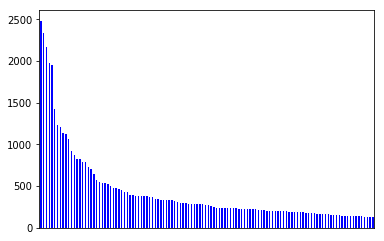

In [28]:
merged_routes.Name.value_counts().head(120).plot(kind='bar', color='b')
_ = plt.xticks([])

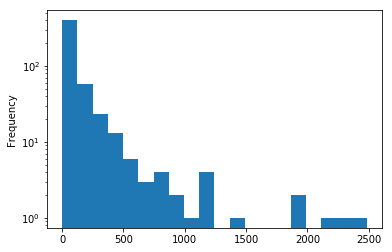

In [29]:
merged_routes.Name.value_counts().plot(kind='hist', log=True, bins=20)

In [30]:
merged_routes.Name.value_counts().describe()

count     520.000000
mean      124.982692
std       275.690204
min         1.000000
25%        14.000000
50%        34.000000
75%       110.250000
max      2482.000000
Name: Name, dtype: float64

In [31]:
reasonably_big_airlines = merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 50].index

In [32]:
merged_routes = merged_routes[merged_routes.Name.isin(reasonably_big_airlines)]

We look at a total of 212 airlines:

In [33]:
merged_routes.Name.unique().shape

(212,)

### Meta-Data analysis

Propotion of international to national flights

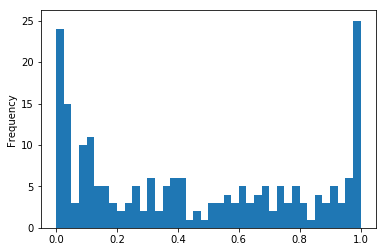

In [45]:
merged_routes.groupby('Name').International.mean().plot(kind='hist', bins=40)

mean distance of flights:

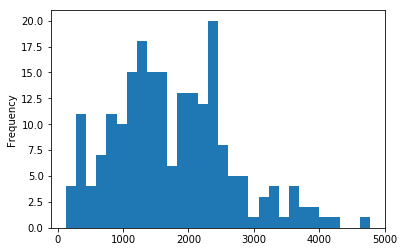

In [49]:
merged_routes.groupby('Name').Distance.mean().plot(kind='hist', bins=30)

Max distance of flights:

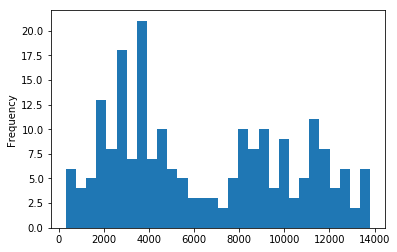

In [50]:
merged_routes.groupby('Name').Distance.max().plot(kind='hist', bins=30)

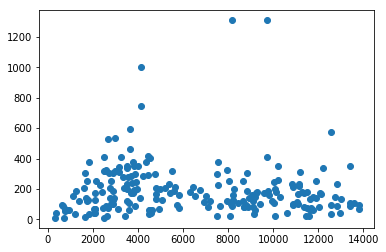

In [40]:
plt.scatter(merged_routes.groupby('Name').Distance.max(),  merged_routes.groupby('Name').Distance.min())

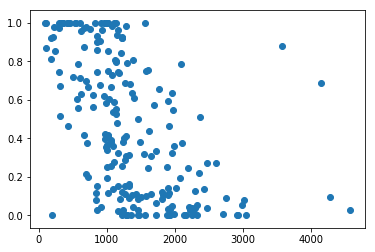

In [43]:
plt.scatter(merged_routes.groupby('Name').Distance.median(),  merged_routes.groupby('Name').International.mean())

shortest distance of flight:

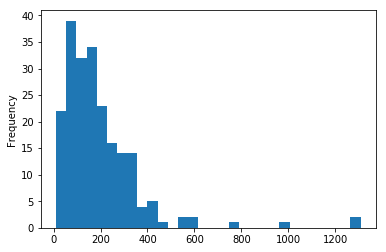

In [59]:
merged_routes.groupby('Name').Distance.min().plot(kind='hist', bins=30)

Proportion of codeshare flights:

In [52]:
merged_routes['Codeshare'] = merged_routes.Codeshare.map(lambda x: 1 if x == 'Y' else 0)

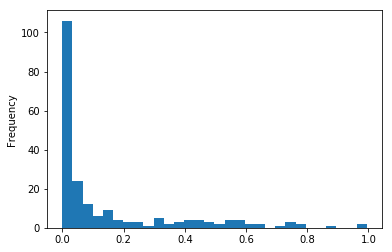

In [55]:
merged_routes.groupby('Name').Codeshare.mean().plot(kind='hist', bins=30)

## Create graph of all airlines:

Create graph with edge having airline associated to

In [44]:
biggest = merged_routes.AirlineNbr.value_counts().head(10).index

In [45]:
edge_attributes = ['Country', 'Name', 'AirlineNbr', 'Distance', 'International']

In [46]:
Airline_Graph = nx.from_pandas_edgelist(merged_routes[merged_routes.AirlineNbr.isin(biggest)], 
                                        source='SourceAirport', 
                                        target='DestinationAirport', 
                                        edge_attr=['Country', 'Name', 'AirlineNbr', 'Distance', 'International'])

In [47]:
color_edges = list(nx.get_edge_attributes(Airline_Graph, 'AirlineNbr').values())

In [48]:
nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


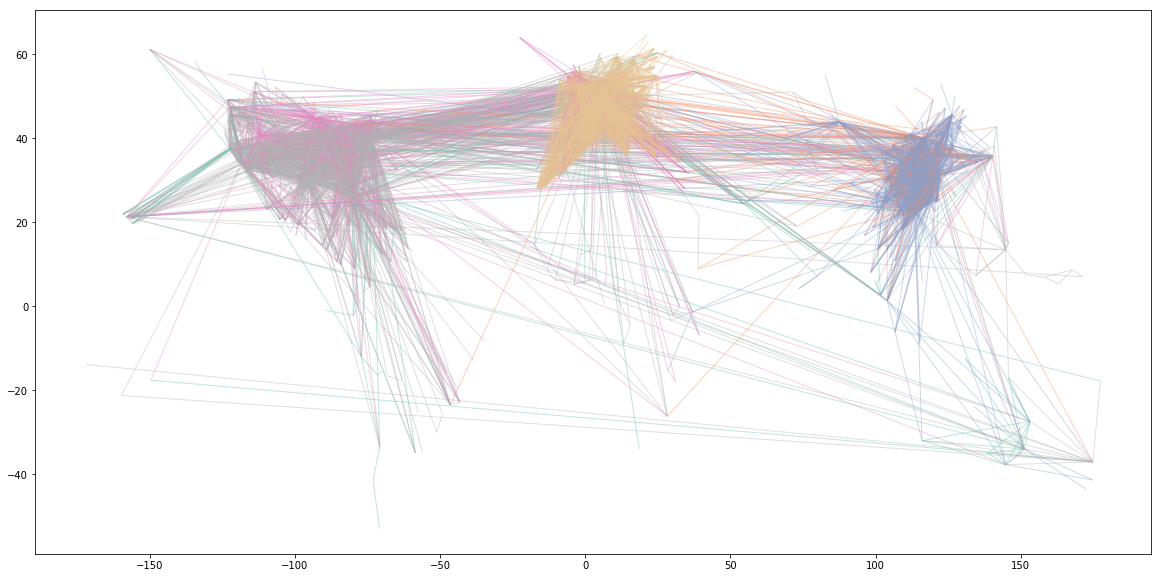

In [49]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(Airline_Graph, 
                 pos=nx.get_node_attributes(Airline_Graph, 'Location'), 
                 edge_color=color_edges, edge_cmap=plt.cm.Set2, node_size=0, labels=dict(), alpha=0.4)

Example analysis of one graph:

In [50]:
def create_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])
    nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')
    return Airline_Graph

In [51]:
Ryanair = create_airline_network('Ryanair')

In [52]:
e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Ryanair).todense())

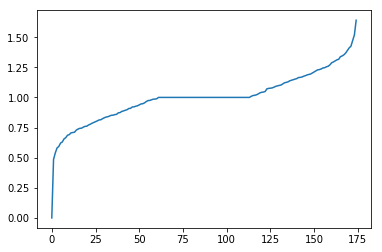

In [53]:
plt.plot(e)

In [54]:
Lufthansa = create_airline_network('Lufthansa')

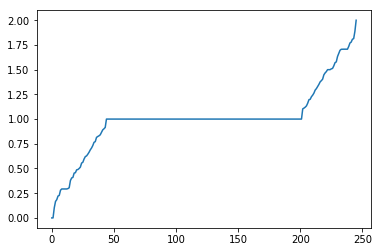

In [55]:
e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Lufthansa).todense())
plt.plot(e)

In [58]:
nx.node_connectivity(Ryanair)

1

{'boxes': [<matplotlib.lines.Line2D at 0xa17be8ba8>],
 'caps': [<matplotlib.lines.Line2D at 0xa17be8d68>,
 'fliers': [<matplotlib.lines.Line2D at 0xa17bb6358>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xa17bb6898>],
 'whiskers': [<matplotlib.lines.Line2D at 0xa17e5c080>,
  <matplotlib.lines.Line2D at 0xa17be8240>]}

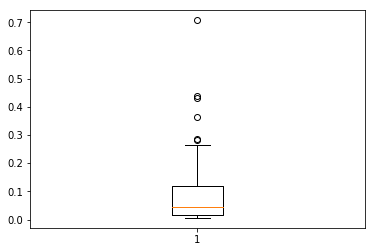

In [59]:
plt.boxplot(nx.degree_centrality(Ryanair).values())

In [60]:
nx.average_clustering(Ryanair)

0.3773615342775362

In [61]:
nx.k_nearest_neighbors(Ryanair)

{1: 82.0,
 2: 68.52272727272727,
 3: 56.833333333333336,
 4: 52.416666666666664,
 5: 52.1625,
 6: 52.55555555555556,
 7: 51.535714285714285,
 8: 45.296875,
 9: 37.7037037037037,
 10: 42.833333333333336,
 11: 44.60606060606061,
 12: 44.791666666666664,
 13: 43.753846153846155,
 14: 41.857142857142854,
 15: 43.43333333333333,
 16: 39.270833333333336,
 18: 34.65555555555556,
 19: 31.157894736842106,
 20: 38.275,
 21: 28.19047619047619,
 22: 34.11363636363637,
 24: 38.208333333333336,
 25: 32.72,
 26: 35.88461538461539,
 27: 25.85185185185185,
 28: 32.357142857142854,
 29: 31.908045977011493,
 30: 32.3,
 32: 33.140625,
 33: 22.575757575757574,
 34: 22.676470588235293,
 35: 30.8,
 36: 28.51388888888889,
 37: 24.243243243243242,
 38: 26.86842105263158,
 39: 29.41025641025641,
 42: 26.285714285714285,
 43: 26.24418604651163,
 44: 25.386363636363637,
 45: 29.244444444444444,
 46: 25.08695652173913,
 49: 28.857142857142858,
 50: 26.5,
 63: 25.26984126984127,
 75: 19.14666666666667,
 76: 23.3684

In [62]:
nx.triangles(Ryanair)

{'AAR': 3,
 'ACE': 100,
 'AGA': 1,
 'AGP': 255,
 'AHO': 101,
 'ALC': 144,
 'AOI': 5,
 'ATH': 11,
 'BCN': 228,
 'BDS': 28,
 'BES': 0,
 'BGY': 456,
 'BHX': 39,
 'BIQ': 4,
 'BLL': 46,
 'BLQ': 189,
 'BOD': 21,
 'BOH': 11,
 'BRE': 98,
 'BRI': 81,
 'BRQ': 0,
 'BRS': 82,
 'BRU': 12,
 'BSL': 1,
 'BTS': 56,
 'BUD': 50,
 'BVA': 244,
 'BVE': 0,
 'BZG': 2,
 'BZR': 9,
 'CAG': 73,
 'CCF': 13,
 'CFE': 0,
 'CFU': 23,
 'CGN': 2,
 'CHQ': 108,
 'CIA': 309,
 'CIY': 15,
 'CRL': 358,
 'CTA': 6,
 'CUF': 1,
 'DLE': 1,
 'DNR': 0,
 'DTM': 14,
 'DUB': 598,
 'EBU': 0,
 'EDI': 145,
 'EFL': 0,
 'EGC': 0,
 'EIN': 147,
 'EMA': 111,
 'ESU': 0,
 'FAO': 65,
 'FCO': 1,
 'FEZ': 24,
 'FKB': 29,
 'FMM': 40,
 'FMO': 0,
 'FNI': 1,
 'FSC': 0,
 'FUE': 56,
 'GDN': 21,
 'GOA': 6,
 'GPA': 0,
 'GRO': 201,
 'GRQ': 1,
 'GSE': 41,
 'HAU': 7,
 'HHN': 177,
 'IBZ': 119,
 'KGS': 11,
 'KIR': 5,
 'KRK': 160,
 'KTW': 7,
 'KUN': 49,
 'LBA': 49,
 'LBC': 1,
 'LDE': 1,
 'LDY': 4,
 'LEI': 4,
 'LEJ': 0,
 'LGW': 2,
 'LIG': 0,
 'LIL': 1,
 'LIS': 24,

In [63]:
nx.diameter(Ryanair)

4

In [64]:
nx.estrada_index(Ryanair)

3090902218553.4897

In [65]:
nx.eccentricity(Ryanair)

{'AAR': 3,
 'ACE': 3,
 'AGA': 3,
 'AGP': 3,
 'AHO': 3,
 'ALC': 3,
 'AOI': 3,
 'ATH': 3,
 'BCN': 3,
 'BDS': 3,
 'BES': 4,
 'BGY': 3,
 'BHX': 3,
 'BIQ': 3,
 'BLL': 3,
 'BLQ': 3,
 'BOD': 3,
 'BOH': 3,
 'BRE': 3,
 'BRI': 3,
 'BRQ': 4,
 'BRS': 3,
 'BRU': 4,
 'BSL': 3,
 'BTS': 3,
 'BUD': 3,
 'BVA': 3,
 'BVE': 4,
 'BZG': 3,
 'BZR': 3,
 'CAG': 3,
 'CCF': 3,
 'CFE': 4,
 'CFU': 3,
 'CGN': 4,
 'CHQ': 3,
 'CIA': 3,
 'CIY': 3,
 'CRL': 3,
 'CTA': 4,
 'CUF': 4,
 'DLE': 4,
 'DNR': 4,
 'DTM': 3,
 'DUB': 3,
 'EBU': 4,
 'EDI': 3,
 'EFL': 4,
 'EGC': 3,
 'EIN': 3,
 'EMA': 3,
 'ESU': 4,
 'FAO': 3,
 'FCO': 4,
 'FEZ': 3,
 'FKB': 3,
 'FMM': 3,
 'FMO': 4,
 'FNI': 3,
 'FSC': 4,
 'FUE': 3,
 'GDN': 3,
 'GOA': 3,
 'GPA': 4,
 'GRO': 3,
 'GRQ': 4,
 'GSE': 3,
 'HAU': 3,
 'HHN': 3,
 'IBZ': 3,
 'KGS': 3,
 'KIR': 3,
 'KRK': 3,
 'KTW': 3,
 'KUN': 3,
 'LBA': 3,
 'LBC': 4,
 'LDE': 3,
 'LDY': 3,
 'LEI': 3,
 'LEJ': 4,
 'LGW': 4,
 'LIG': 4,
 'LIL': 4,
 'LIS': 3,
 'LNZ': 4,
 'LPA': 3,
 'LPL': 3,
 'LPP': 4,
 'LRH': 3,
 'LTN': 3,

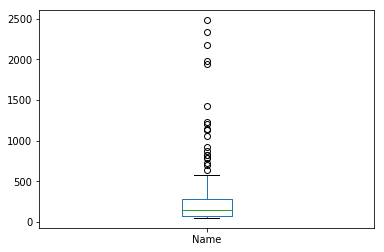

In [66]:
merged_routes.Name.value_counts().plot(kind='box')

In [67]:
merged_routes.Name.value_counts().describe()

count     212.000000
mean      278.995283
std       382.714531
min        52.000000
25%        77.750000
50%       152.500000
75%       290.500000
max      2482.000000
Name: Name, dtype: float64

In [68]:
merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 100]

Ryanair                           2482
American Airlines                 2340
United Airlines                   2172
Delta Air Lines                   1977
US Airways                        1947
China Southern Airlines           1422
Air China                         1236
China Eastern Airlines            1211
Southwest Airlines                1140
easyJet                           1130
Air France                        1063
Lufthansa                          919
Alitalia                           877
Iberia Airlines                    829
KLM Royal Dutch Airlines           826
Shenzhen Airlines                  789
Air Berlin                         786
AirTran Airways                    726
Air Canada                         701
Turkish Airlines                   640
Norwegian Air Shuttle              576
British Airways                    545
Hainan Airlines                    539
All Nippon Airways                 535
Alaska Airlines                    530
Scandinavian Airlines Sys

In [69]:
merged_routes.Country.value_counts().head(20)

United States           12295
China                    7000
United Kingdom           3019
Germany                  2829
Ireland                  2708
France                   1750
Russia                   1501
Canada                   1381
India                    1313
Japan                    1189
Italy                    1138
Spain                    1123
Netherlands              1119
Turkey                    979
Australia                 971
United Arab Emirates      959
Brazil                    829
Taiwan                    820
Norway                    781
Mexico                    740
Name: Country, dtype: int64

In [70]:
merged_routes.Codeshare.value_counts()

N    44934
Y    14213
Name: Codeshare, dtype: int64

In [71]:
Low_cost = ['Southwest Airlines', 'Virgin America', 'AirAsia', 'Ryanair','easyJet', 'WestJet', 'Pegasus Airlines', 'Spirit Airlines', 'Mango']

In [72]:
merged_routes[merged_routes.Name.isin(Low_cost)].Name.value_counts()

Ryanair               2482
Southwest Airlines    1140
easyJet               1130
WestJet                341
Spirit Airlines        242
Pegasus Airlines       240
AirAsia                180
Virgin America          66
Name: Name, dtype: int64

In [73]:
merged_routes.head()

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
2,Aigle Azur,AAF,France,AAE,MRS,N,0,319,1,0,767.018673
3,Aigle Azur,AAF,France,AAE,ORY,N,0,319,1,0,1393.826774
4,Aigle Azur,AAF,France,ALG,CDG,N,0,319,1,0,1369.896055
5,Aigle Azur,AAF,France,ALG,LIL,N,0,320,1,0,1541.323265
6,Aigle Azur,AAF,France,ALG,LYS,N,0,320 319,1,0,1015.406701


In [74]:
def draw_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])

    plt.figure(figsize=(10, 10))
    centrality = nx.betweenness_centrality(Airline_Graph)
    size = np.array(list(centrality.values()))*1000
    nx.draw_spring(Airline_Graph, node_size=size, width=0.1)
    plt.title(airline)
    plt.show()
    e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Airline_Graph).todense())
    plt.plot(e)
    plt.show()
    plt.plot(nx.laplacian_spectrum(Airline_Graph))
    plt.show()
    plt.boxplot(nx.degree_centrality(Airline_Graph).values())
    plt.show()

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


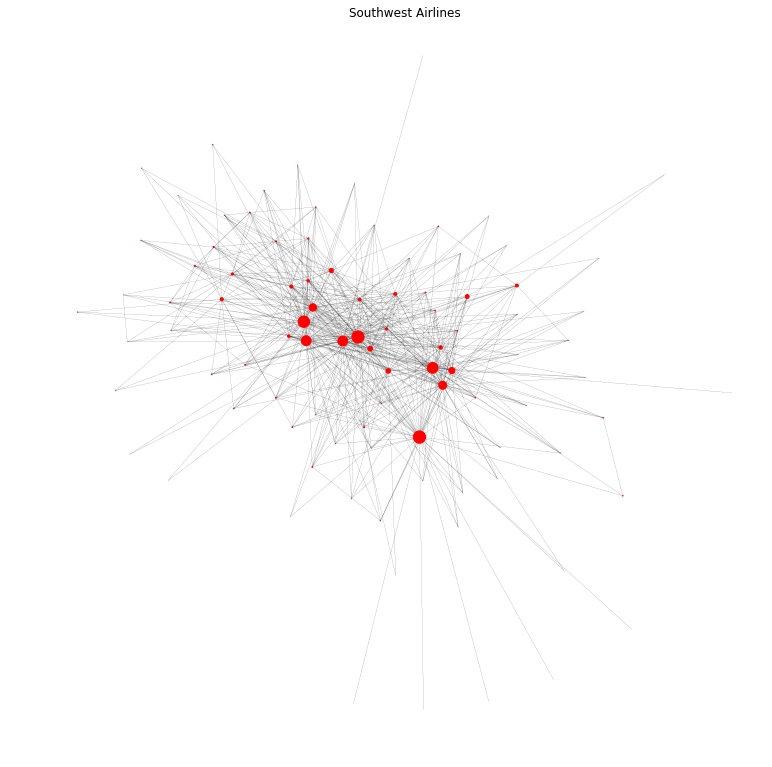

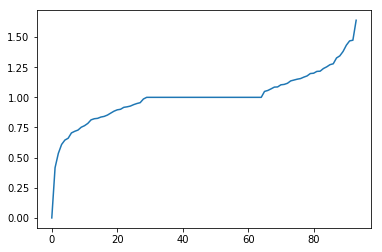

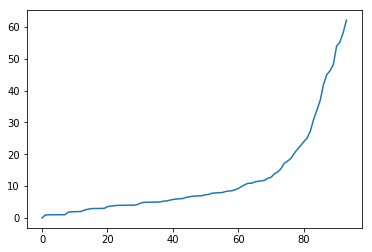

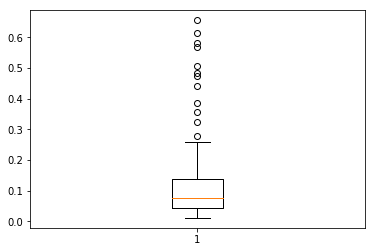

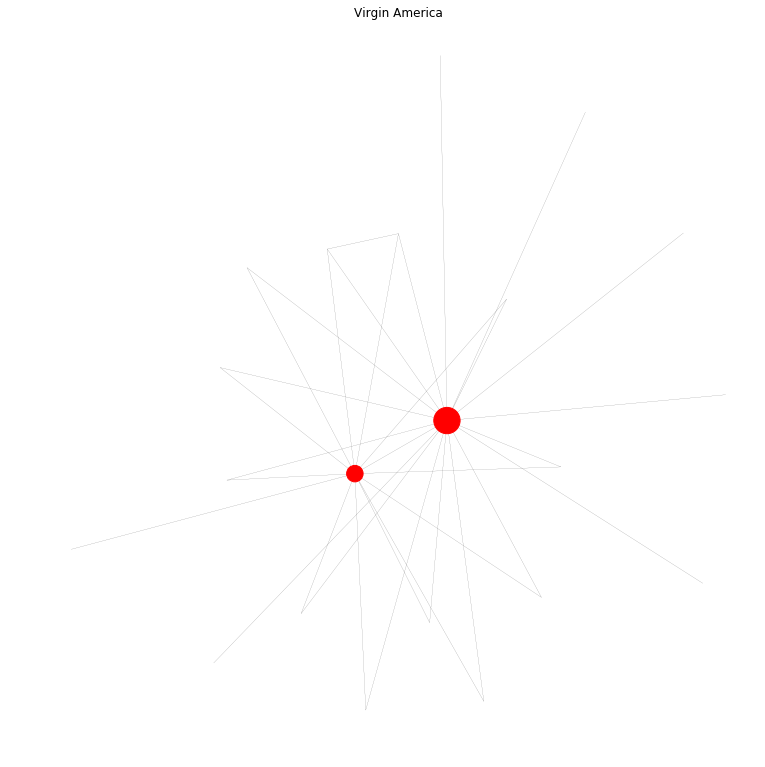

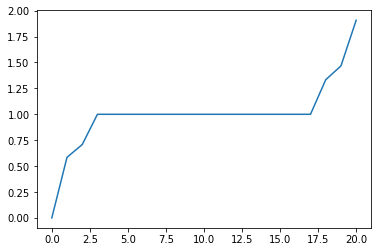

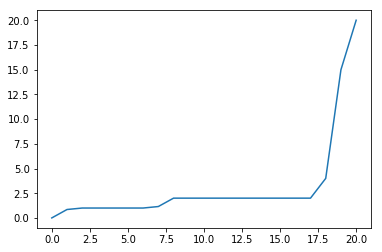

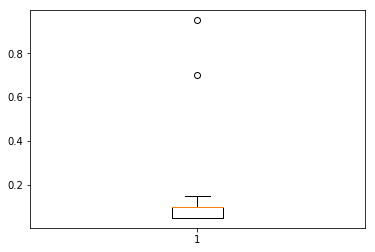

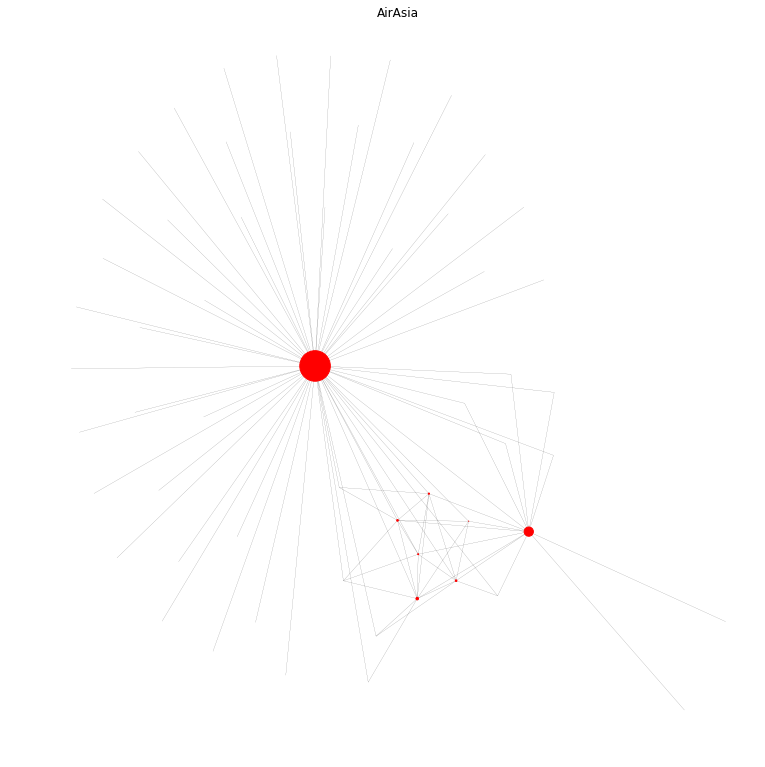

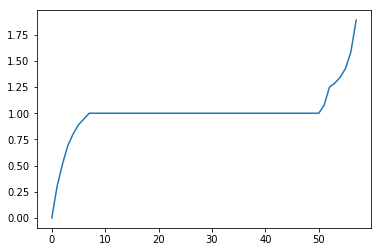

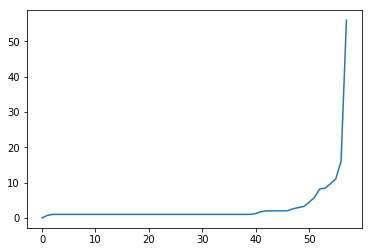

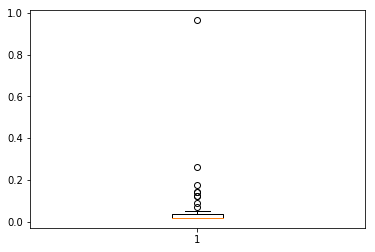

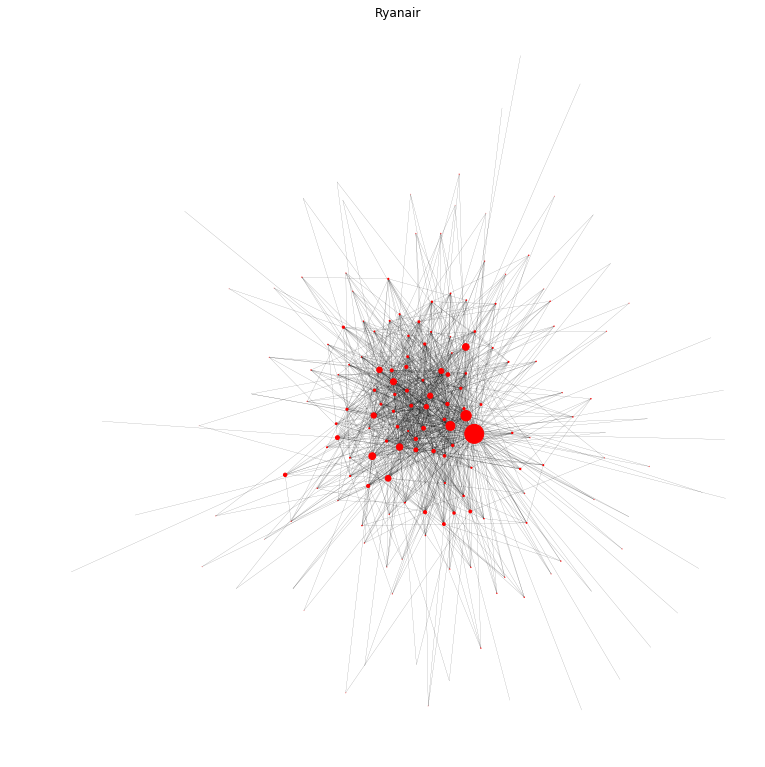

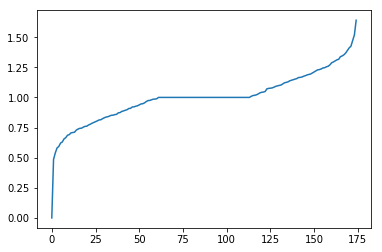

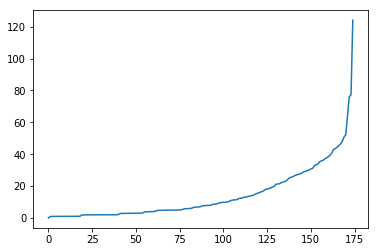

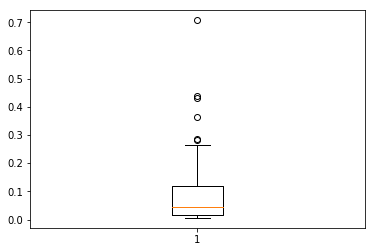

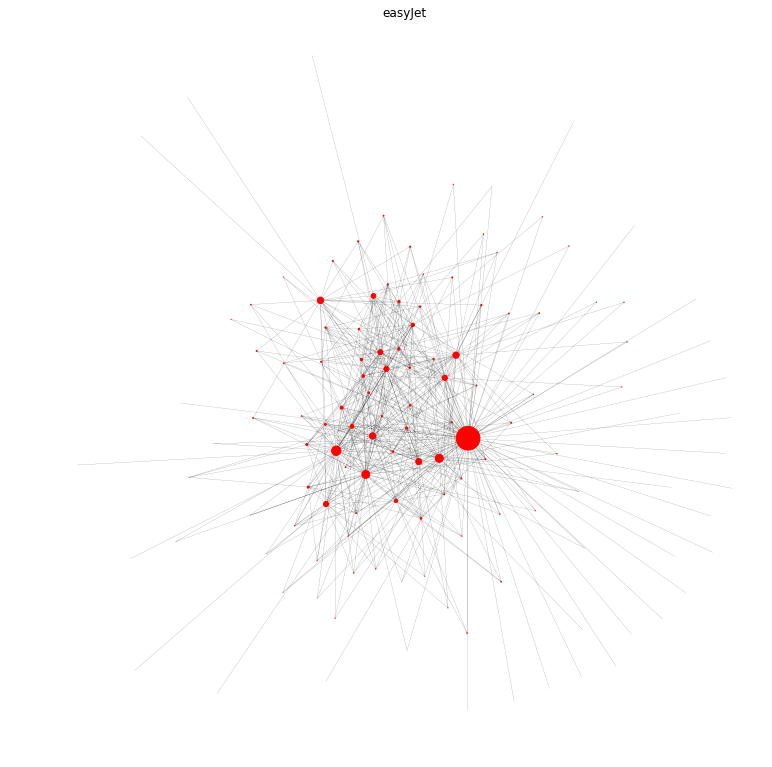

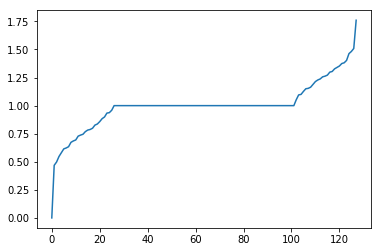

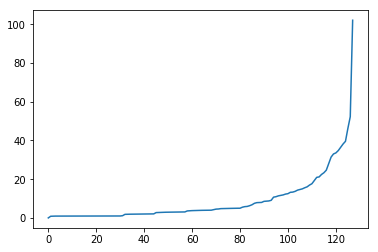

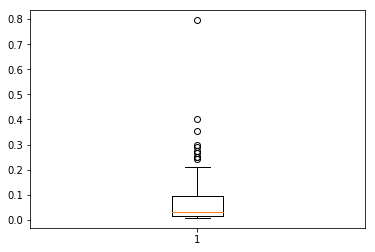

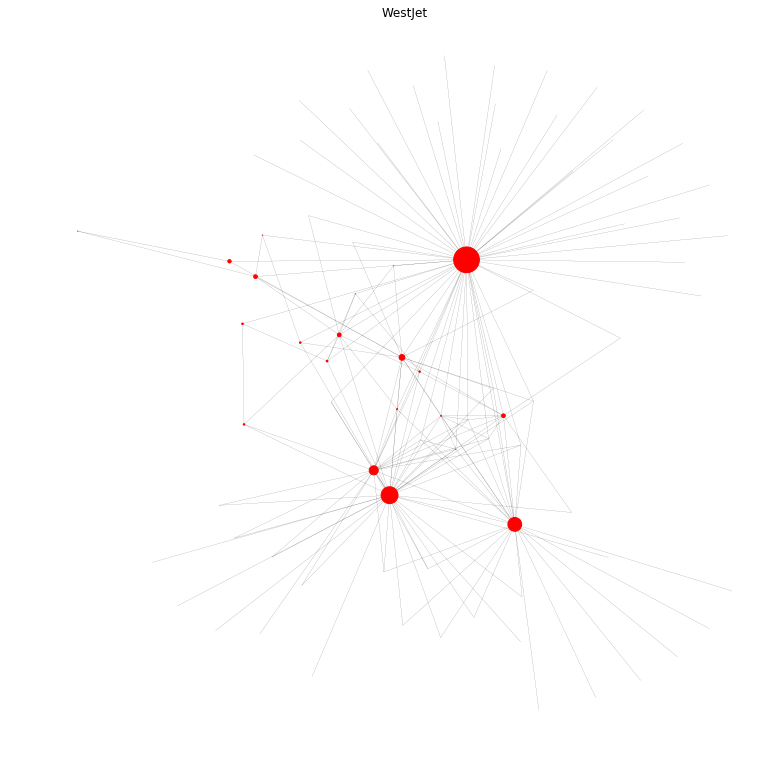

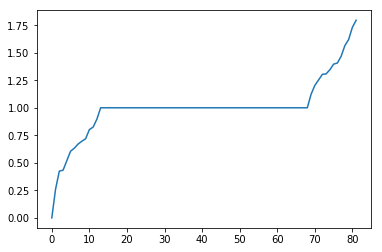

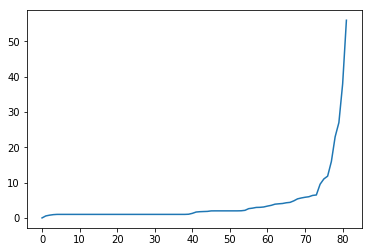

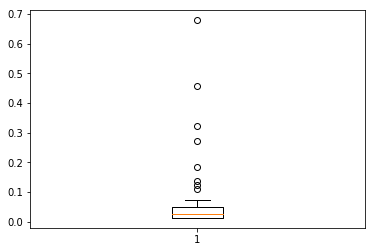

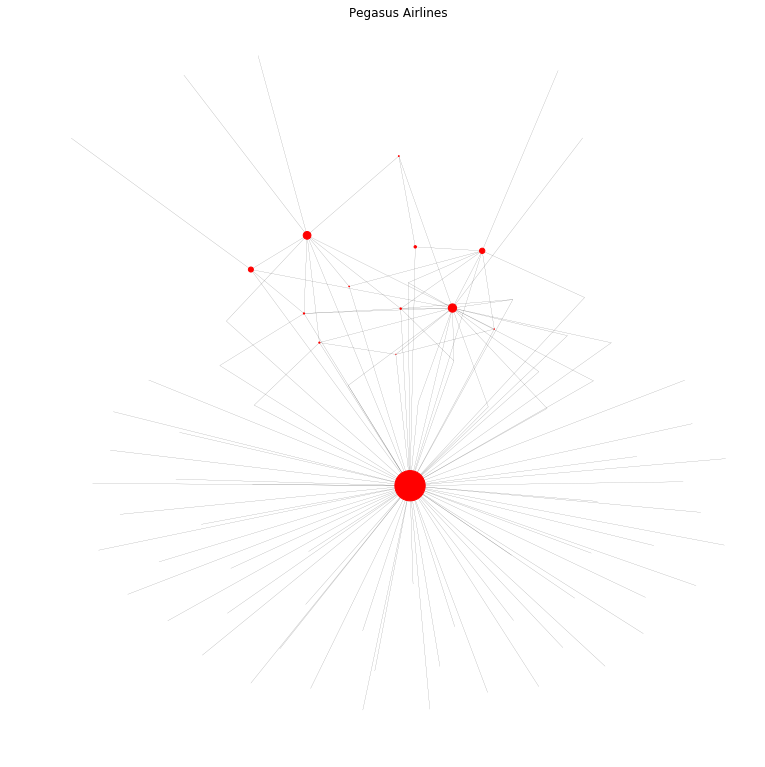

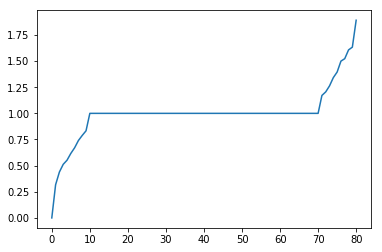

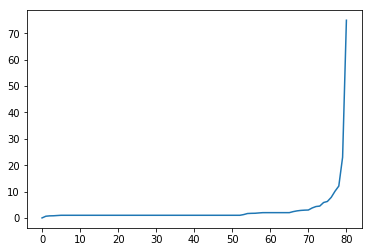

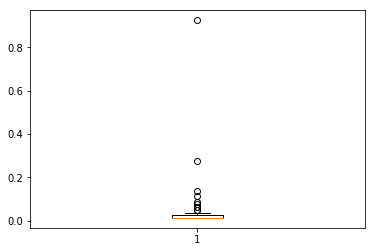

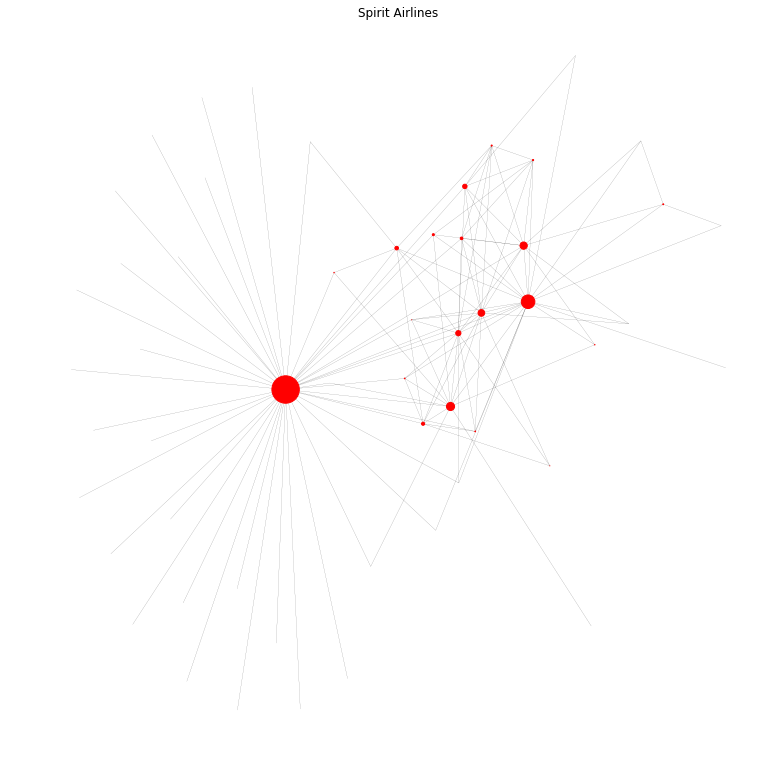

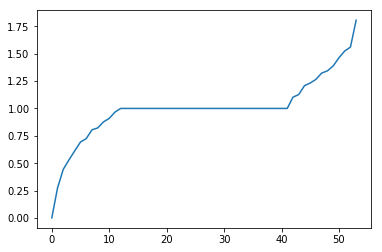

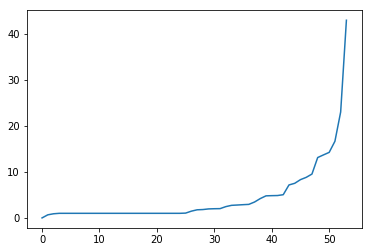

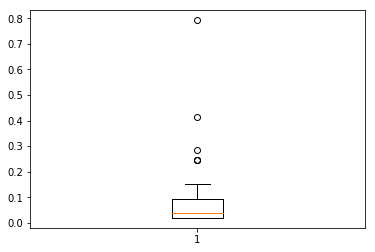

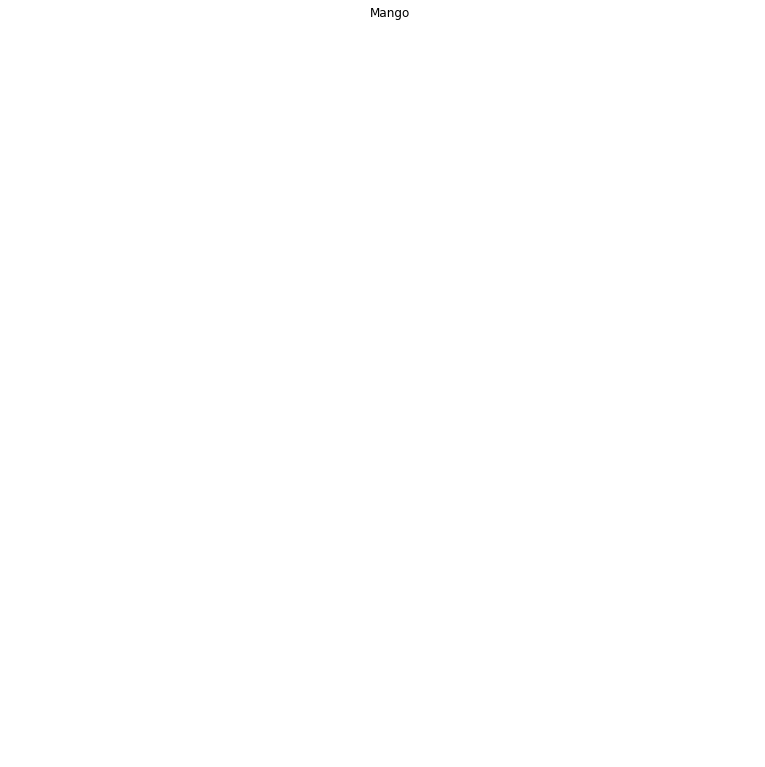

NetworkXError: Graph has no nodes or edges

In [75]:
for cheap in Low_cost:
    draw_airline_network(cheap)

In [76]:
Best_Airlines = ['Singapore Airlines', 'Emirates', 'Lufthansa', 'Qatar Airways', 'Cathay Pacific']

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


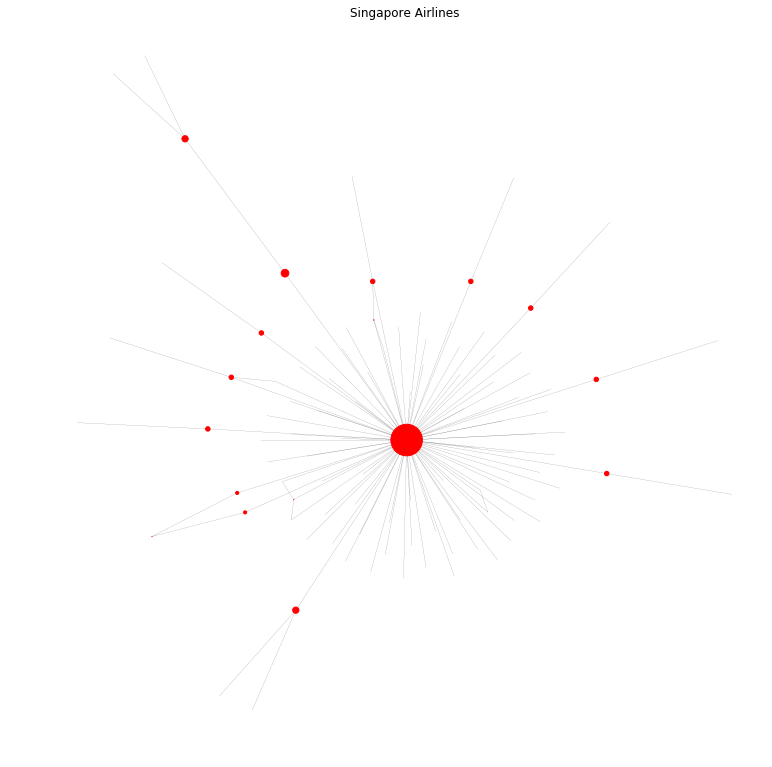

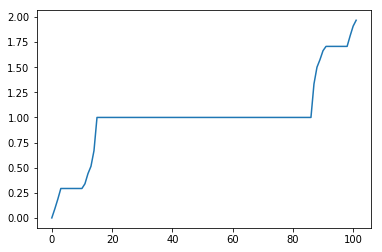

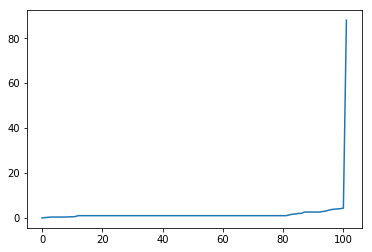

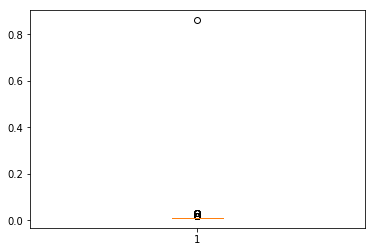

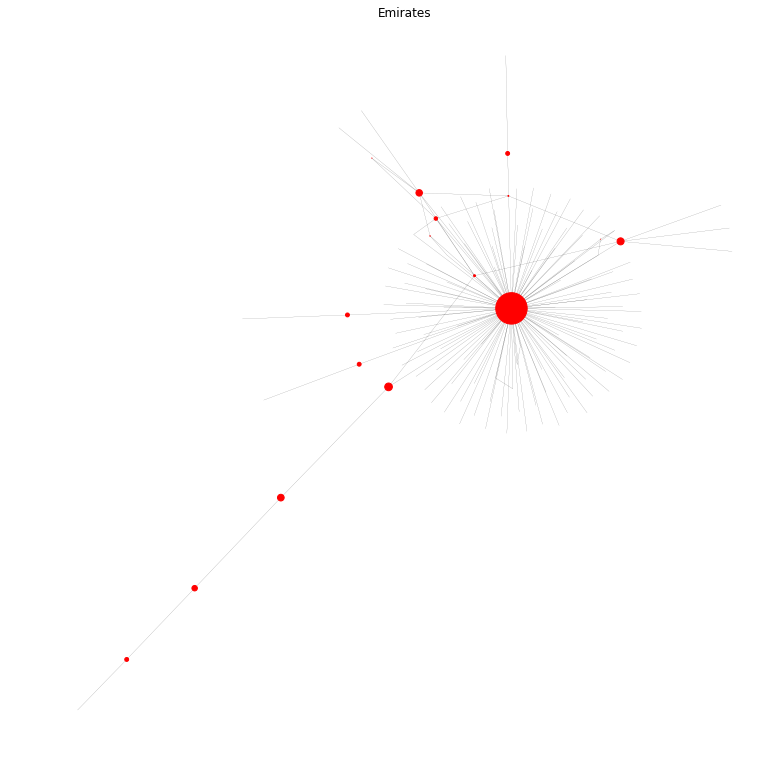

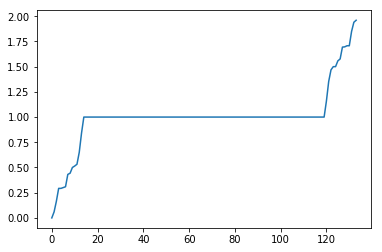

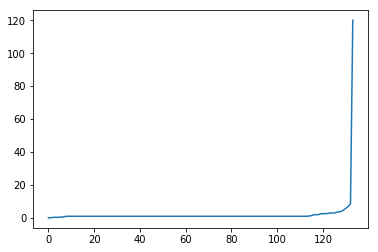

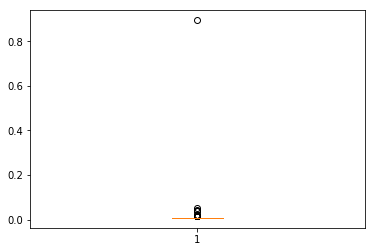

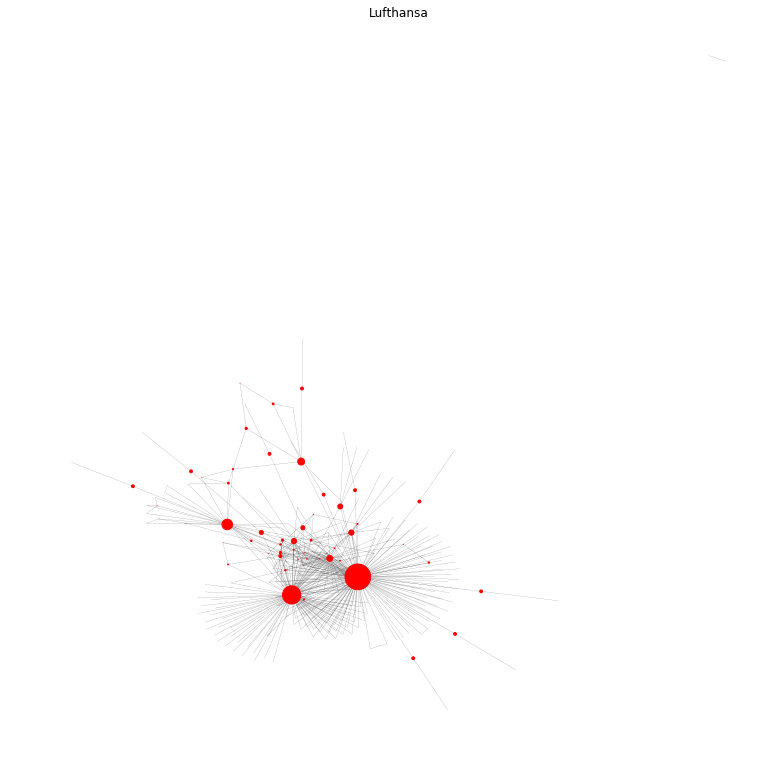

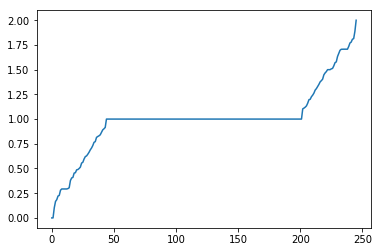

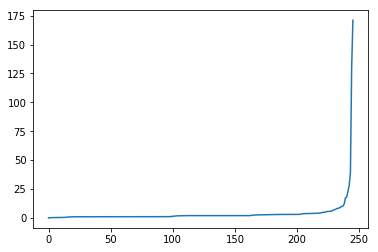

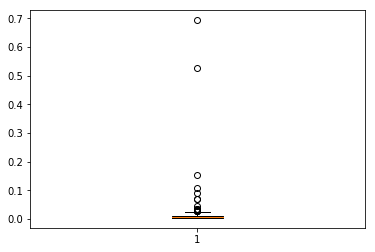

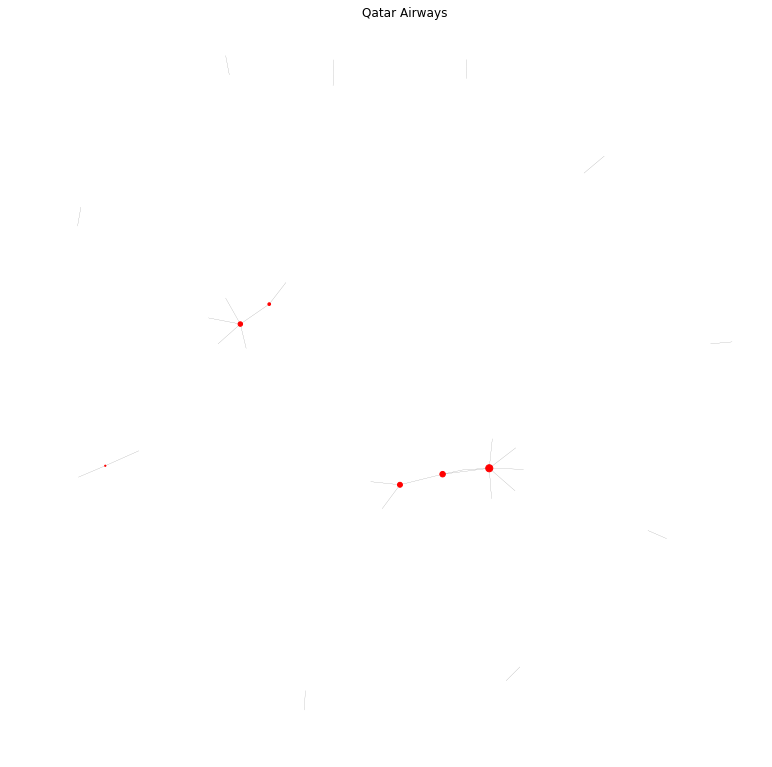

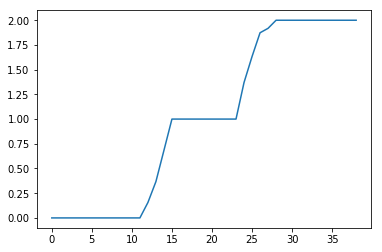

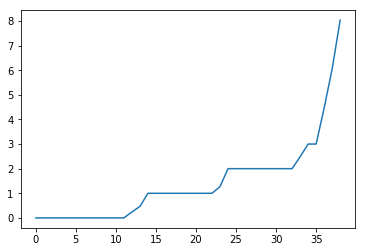

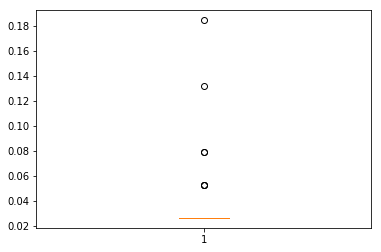

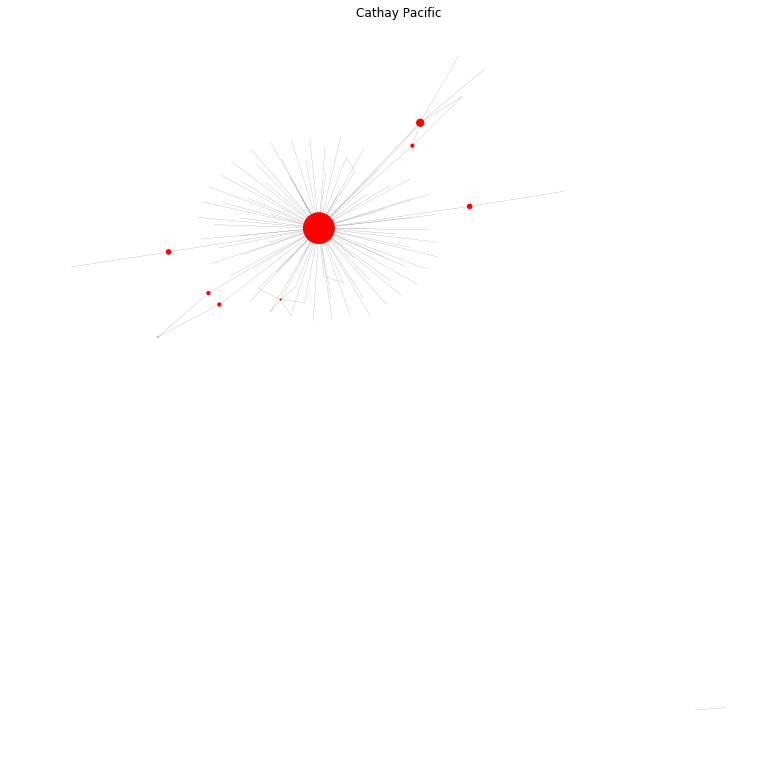

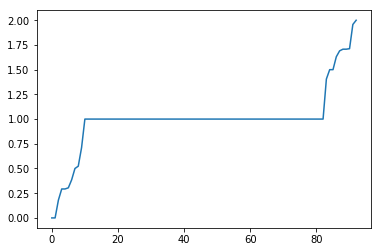

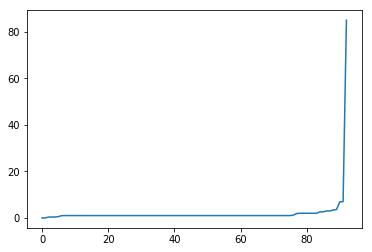

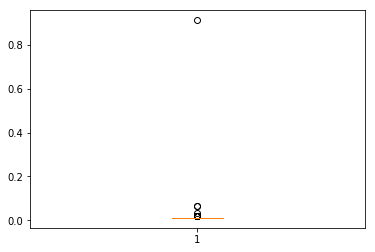

In [77]:
for best in Best_Airlines:
    draw_airline_network(best)

In [78]:
Large_Airlines = ['Delta Air Lines', 'Air France', 'China Southern Airlines', 'Turkish Airlines', 'American Airlines']

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


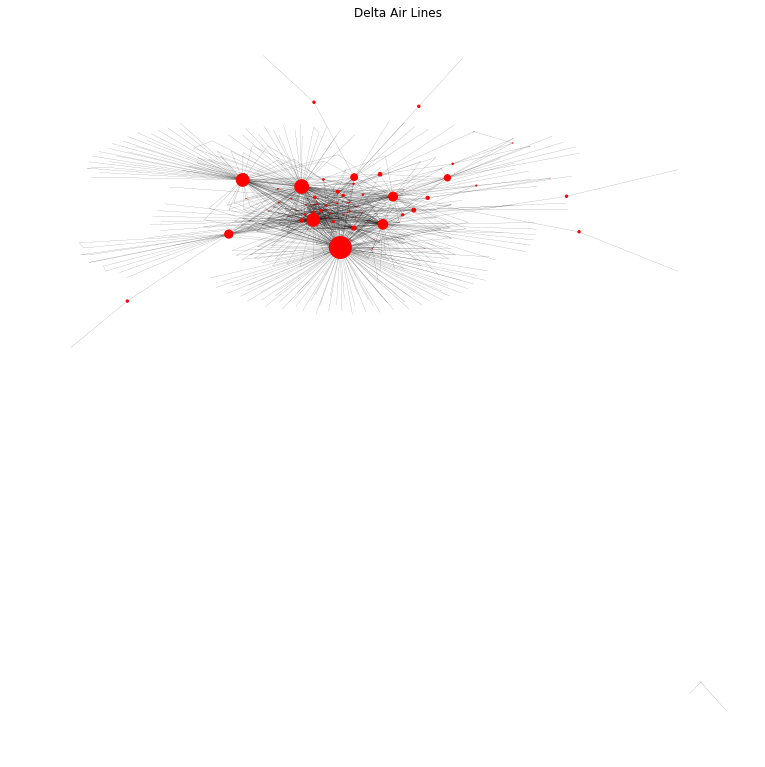

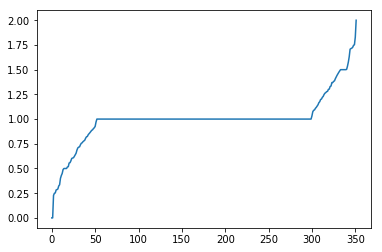

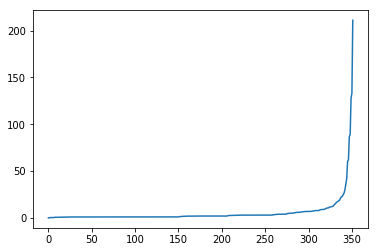

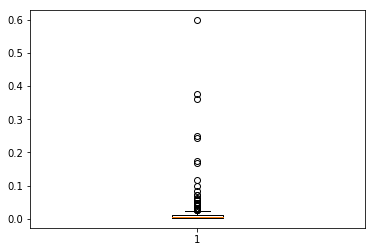

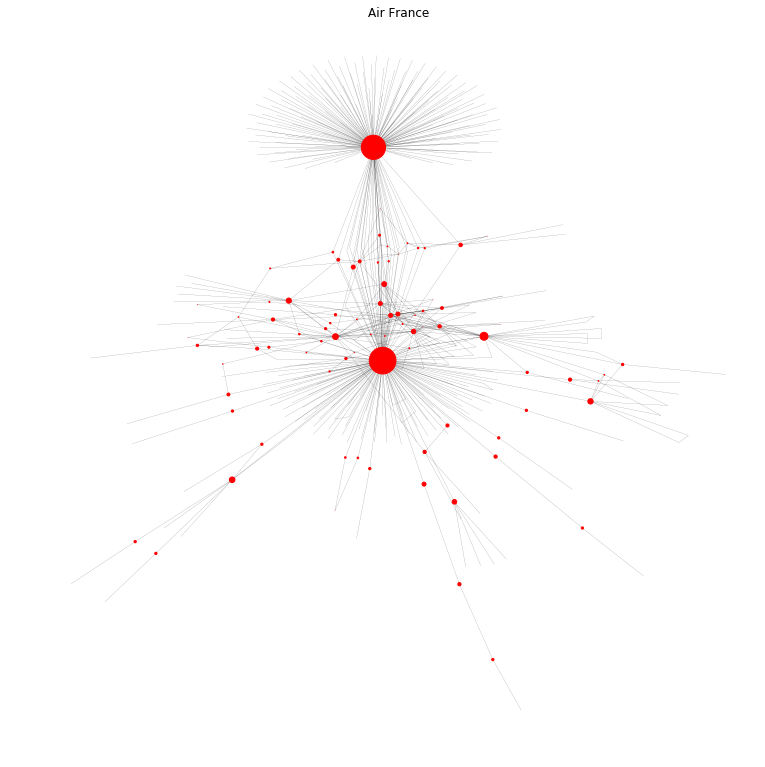

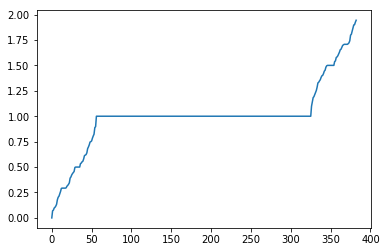

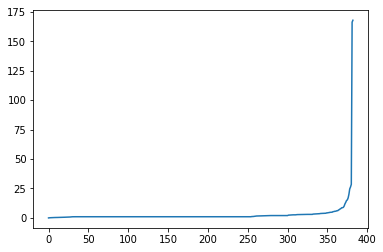

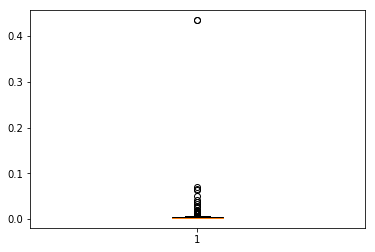

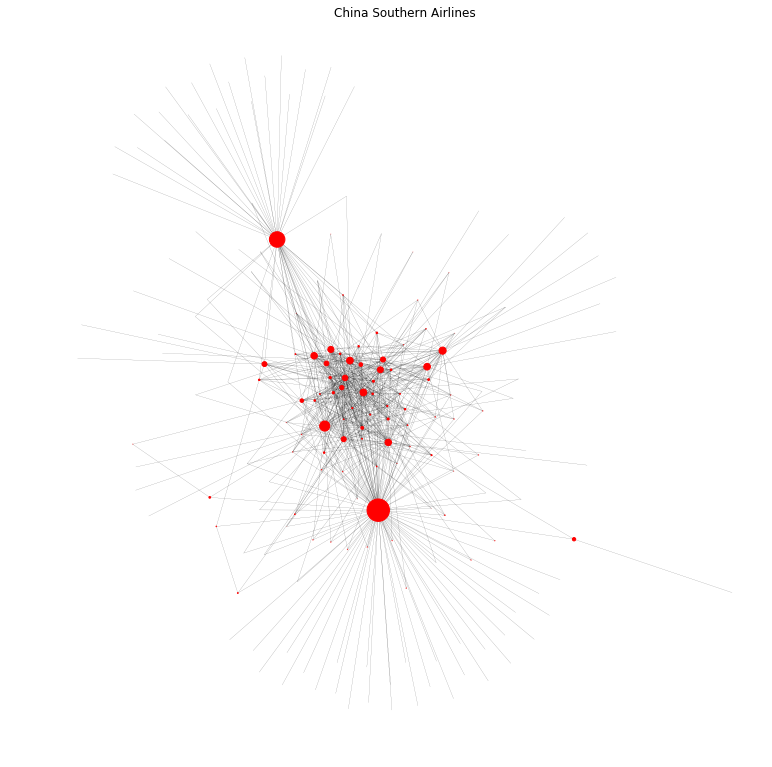

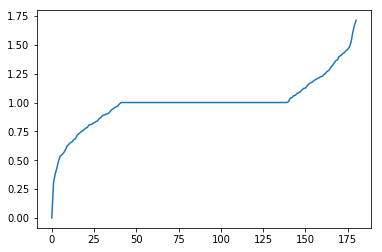

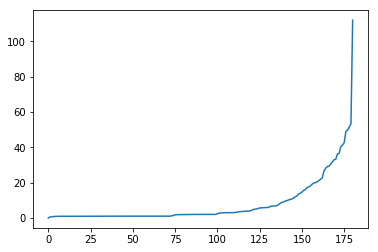

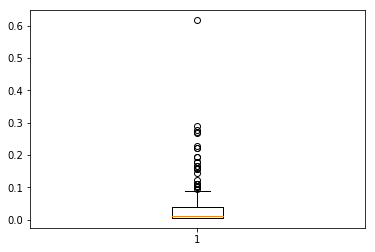

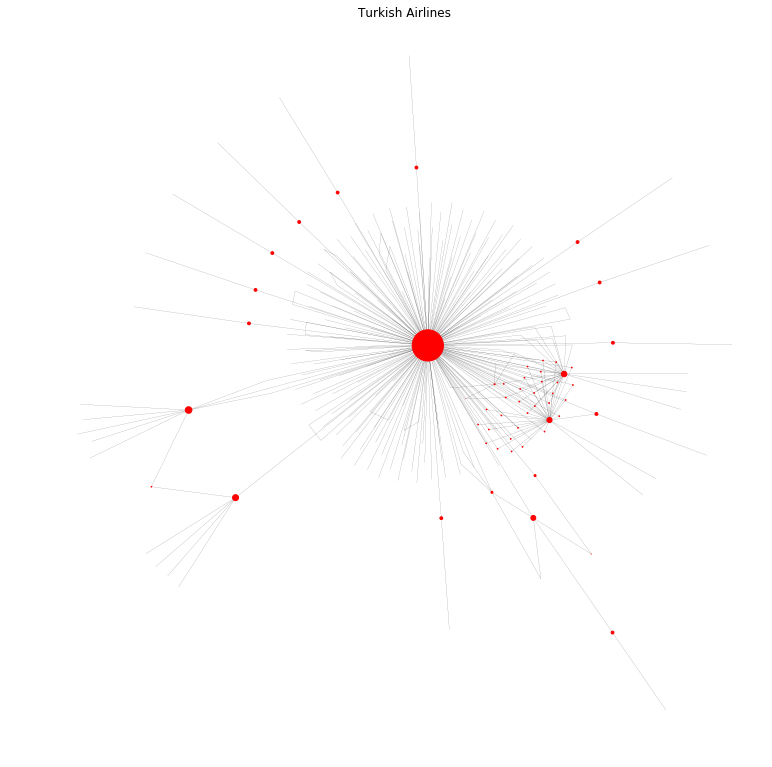

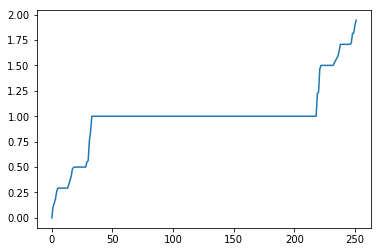

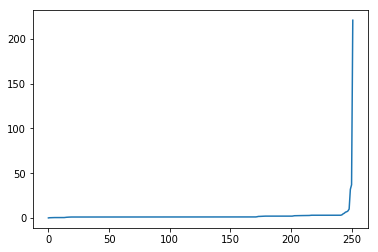

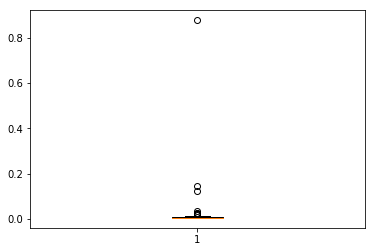

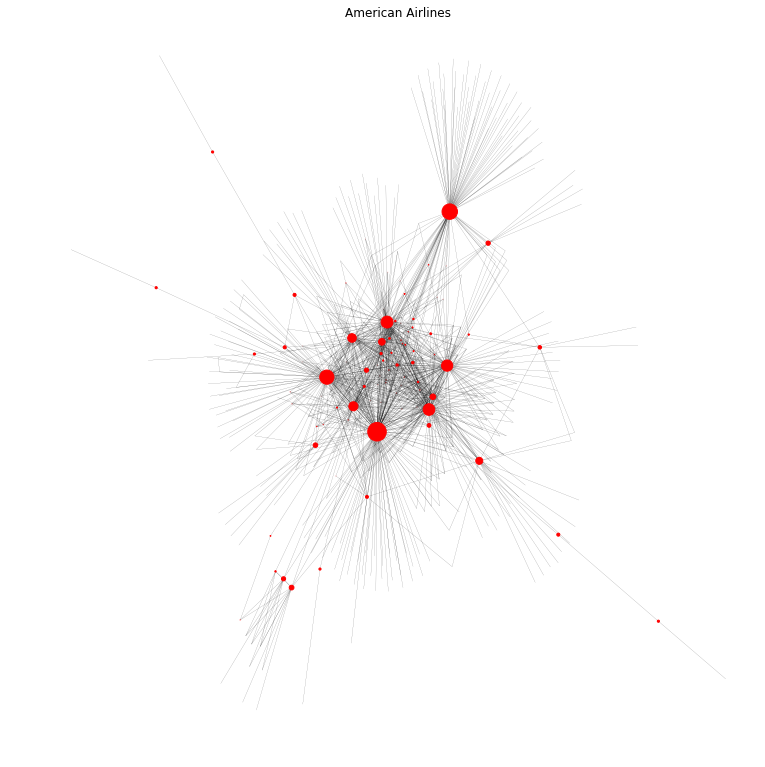

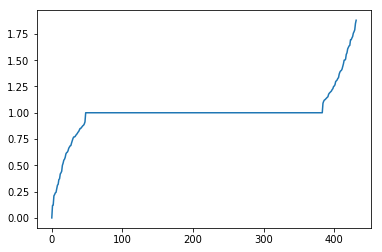

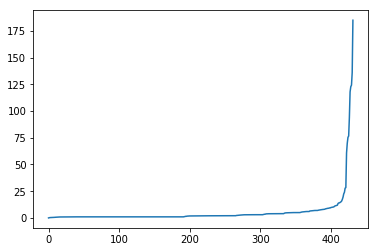

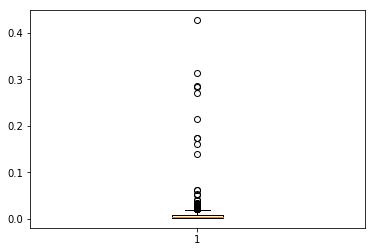

In [79]:
for best in Large_Airlines:
    draw_airline_network(best)

In [80]:
merged_routes.Name.unique()

array(['Aigle Azur', 'American Airlines', 'Asiana Airlines',
       'Allegiant Air', 'Air Europa', 'Aegean Airlines',
       'Aeroflot Russian Airlines', 'Air France', 'Azerbaijan Airlines',
       'Air Berlin', 'Air India Limited', 'Air Bourbon', 'Air One',
       'Air Sahara', 'Air Malta', 'Air Macau', 'AeroMéxico',
       'All Nippon Airways', 'Air Niugini', 'Air Arabia', 'Air Canada',
       'Air Baltic', 'Air New Zealand', 'Aerolineas Argentinas',
       'Alaska Airlines', 'Austrian Airlines', 'Abu Dhabi Amiri Flight',
       'Avianca - Aerovias Nacionales de Colombia', 'Air Vanuatu',
       'Air India Express', 'AirAsia', 'Alitalia', 'Air Foyle',
       'Air Tahiti', 'Air China', 'Aero Condor Peru', 'Air Algerie',
       'Aer Lingus', 'Air Pacific', 'Air Greenland', 'Air Astana',
       'Air Madagascar', 'Airlinair', 'Aircompany Yakutia',
       'Airlines PNG', 'AirTran Airways', 'Air Transat',
       'British Airways', 'Bahamasair', 'Bangkok Airways', 'Bering Air',
       'Belav

In [81]:
Chinese = ['China Southern Airlines', 'China Eastern Airlines', 'Air China']

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


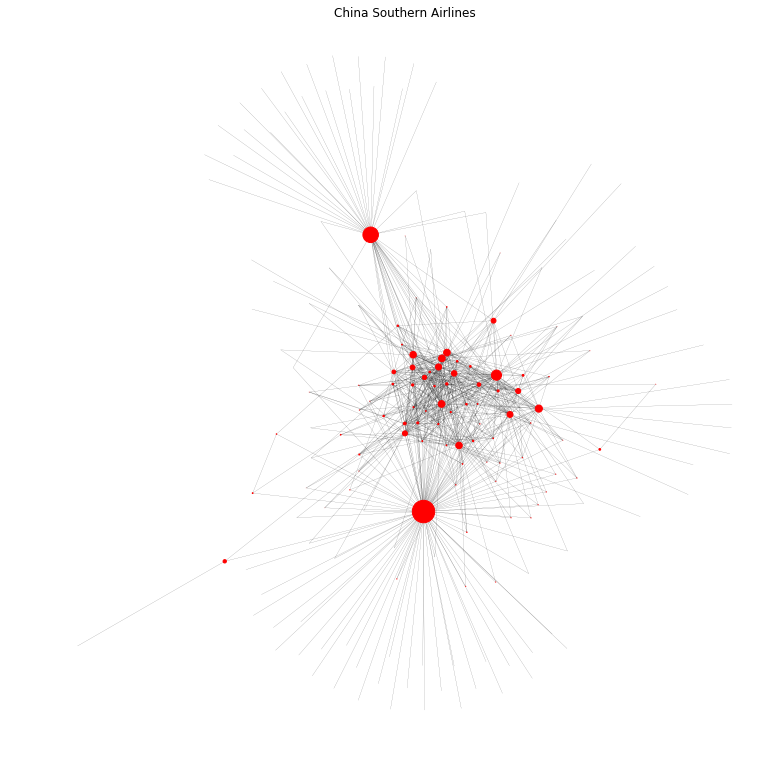

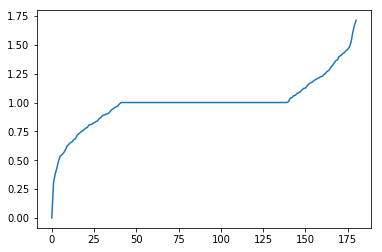

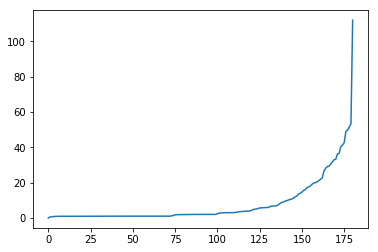

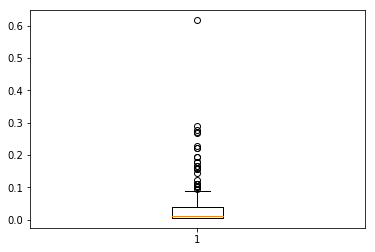

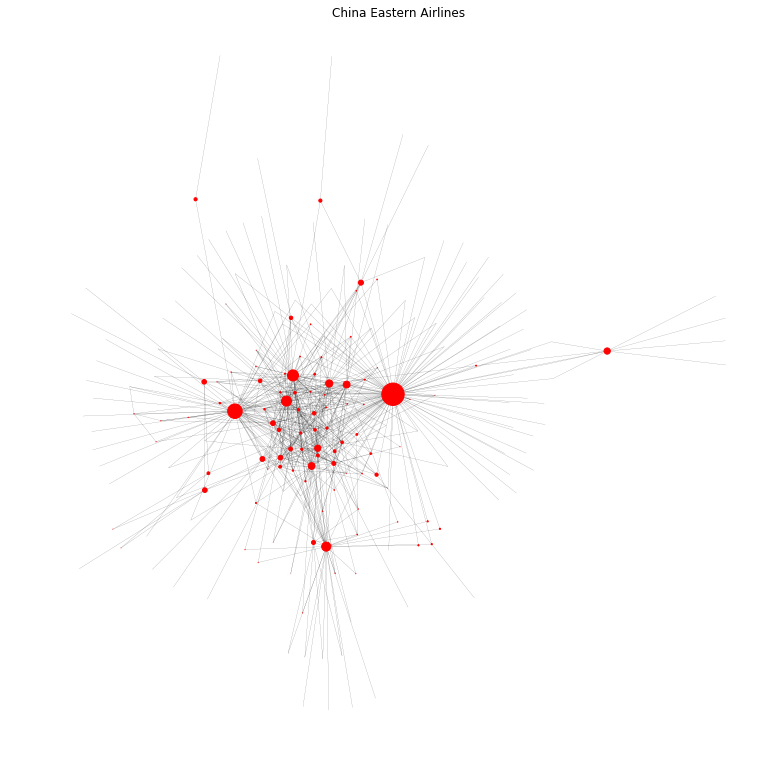

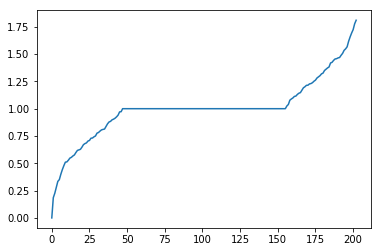

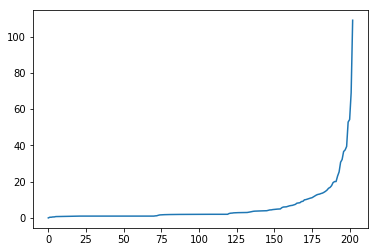

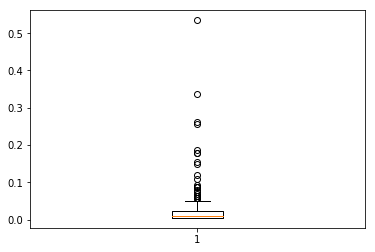

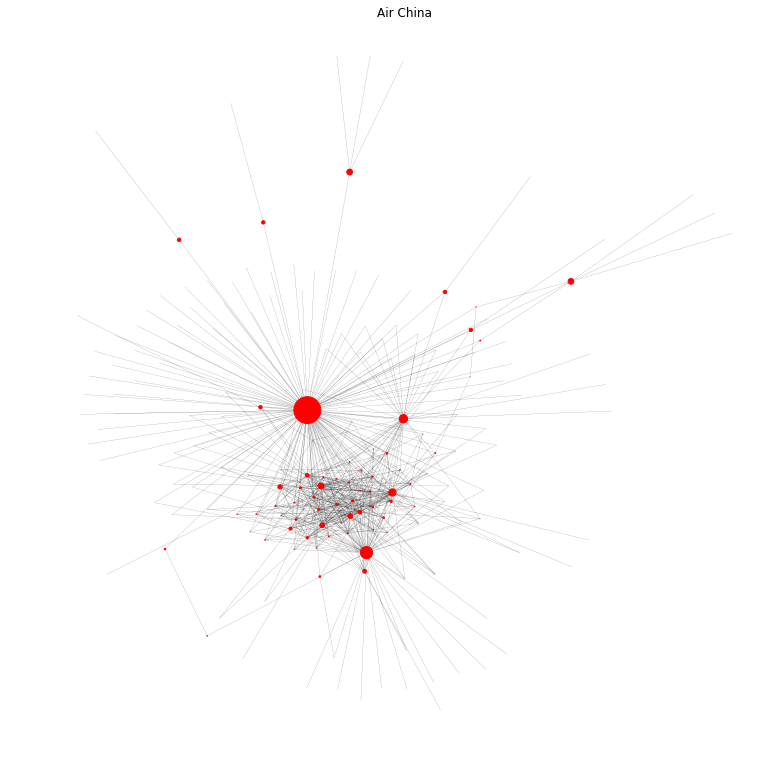

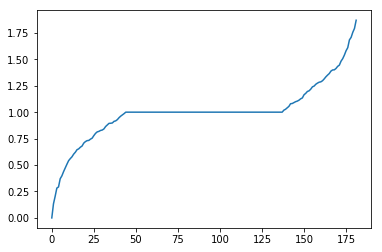

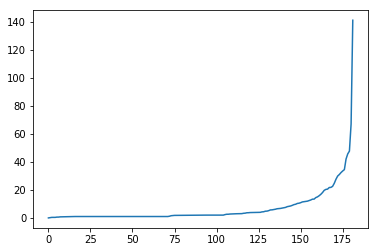

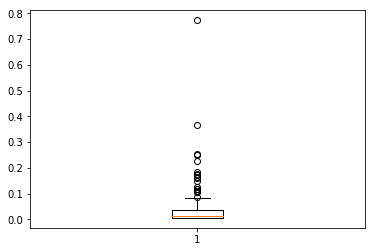

In [82]:
for best in Chinese:
    draw_airline_network(best)

## Adding in external information: for relected airlines - case study

In [83]:
Delays_data = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - Delays data (raw).csv')

In [84]:
Airline_list = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - 🏬 Airlines.csv')

In [85]:
set(Airline_list.name.map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

{'aegean airlines',
 'aer lingus',
 'aerolineas argentinas',
 'air astana',
 'air canada',
 'air china',
 'air europa',
 'air france',
 'air new zealand',
 'air transat',
 'alaska airlines',
 'alitalia',
 'allegiant air',
 'american airlines',
 'asiana airlines',
 'austrian airlines',
 'bangkok airways',
 'british airways',
 'cathay pacific',
 'cebu pacific',
 'china eastern airlines',
 'china southern airlines',
 'copa airlines',
 'croatia airlines',
 'czech airlines',
 'delta air lines',
 'easyjet',
 'egyptair',
 'emirates',
 'ethiopian airlines',
 'etihad airways',
 'eva air',
 'finnair',
 'flybe',
 'frontier airlines',
 'garuda indonesia',
 'hainan airlines',
 'hawaiian airlines',
 'icelandair',
 'iran air',
 'jet airways',
 'kenya airways',
 'korean air',
 'kuwait airways',
 'lufthansa',
 'luxair',
 'malaysia airlines',
 'middle east airlines',
 'oman air',
 'pakistan international airlines',
 'pegasus airlines',
 'qantas',
 'qatar airways',
 'royal air maroc',
 'ryanair',
 'shand

In [86]:
merged_routes.Name.head()

2    Aigle Azur
3    Aigle Azur
4    Aigle Azur
5    Aigle Azur
6    Aigle Azur
Name: Name, dtype: object

In [87]:
set(Delays_data['On-time'].map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

{'air arabia',
 'air baltic',
 'air canada',
 'air china',
 'air france',
 'airasia',
 'alitalia',
 'american airlines',
 'asiana airlines',
 'azul',
 'bangkok airways',
 'british airways',
 'cathay pacific',
 'delta air lines',
 'easyjet',
 'egyptair',
 'emirates',
 'ethiopian airlines',
 'flybe',
 'frontier airlines',
 'germanwings',
 'indonesia airasia',
 'jetblue airways',
 'korean air',
 'lufthansa',
 'qantas',
 'qatar airways',
 'royal jordanian',
 'singapore airlines',
 'skymark airlines',
 'southwest airlines',
 'spicejet',
 'spirit airlines',
 'srilankan airlines',
 'thai airasia',
 'turkish airlines',
 'united airlines',
 'westjet'}